In [3]:
import gzip
import numpy as np
from collections import defaultdict

In [4]:
def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

In [87]:
from random import shuffle
data = []
for l in readGz("train.json.gz"):
    data.append(l)

print(data[0])
#shuffle(data)
print(data[0])

trainData, validData = np.array_split(data, 2)


{'rating': 5.0, 'businessID': 'B408037852', 'reviewText': "This is where i go to shop for gifts from my mom. She loves this stuff. Cna't get enough. I like that you can customize the items. Store is well alid out and shoppable.", 'userID': 'U093387342', 'reviewTime': 'Mar 24, 2013', 'categories': ["Women's Clothing Store", 'Fashion Accessories Store', 'Shoe Store'], 'reviewHash': 'R471510664', 'unixReviewTime': 1364143460}
{'rating': 5.0, 'businessID': 'B408037852', 'reviewText': "This is where i go to shop for gifts from my mom. She loves this stuff. Cna't get enough. I like that you can customize the items. Store is well alid out and shoppable.", 'userID': 'U093387342', 'reviewTime': 'Mar 24, 2013', 'categories': ["Women's Clothing Store", 'Fashion Accessories Store', 'Shoe Store'], 'reviewHash': 'R471510664', 'unixReviewTime': 1364143460}


In [89]:
allRatings = []
userRatings = defaultdict(dict)
busRatings = defaultdict(dict)

for d in trainData:
    user, bus, rating = d['userID'], d['businessID'], d['rating']
    allRatings.append(rating)
    userRatings[user][bus] = rating
    busRatings[bus][user] = rating

globalAvg = sum(allRatings)/len(allRatings)

print(globalAvg)

4.18703


In [133]:
vallRatings = []
vuserRatings = defaultdict(dict)
vbusRatings = defaultdict(dict)

for d in validData:
    user, bus, rating = d['userID'], d['businessID'], d['rating']
    vallRatings.append(rating)
    vuserRatings[user][bus] = rating
    vbusRatings[bus][user] = rating

predRatings = [globalAvg for x in range(100000)]

In [134]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE_alpha = mean_squared_error(vallRatings, predRatings)
print(MSE_alpha)

0.7483437445


In [135]:
def alphaUpdate():
    global alpha
    global betaU
    global betaI
    total = 0;
    count = 0
    for u in userRatings:
        for b in userRatings[u]:
            if(u in betaU):
                total -= betaU[u]
            if(bus in betaI):
                total -= betaI[b]
            total += userRatings[u][b]
            count += 1
    alpha = total/count
    #print(alpha)
#Test
#alphaUpdate()

In [136]:
def betaUUpdate(lambdaval):
    global alpha
    global betaU
    global betaI
    total = 0
    count = lambdaval
    for u in userRatings:
        for b in userRatings[u]:
            total -= alpha
            if(bus in betaI):
                total -= betaI[b]
            total += userRatings[u][b]
            count += 1
        betaU[u] = total/count
        total = 0
        count = lambdaval
    #print(len(betaU))

In [137]:
def betaIUpdate(lambdaval):
    global alpha
    global betaU
    global betaI
    total = 0
    count = lambdaval
    for b in busRatings:
        for u in busRatings[b]:
            total -= alpha
            if(user in betaU):
                total -= betaU[u]
            total += busRatings[b][u]
            count += 1
        betaI[b] = total/count
        total = 0
        count = lambdaval
    #print(len(betaI))

In [138]:
alpha = 0
betaU = defaultdict(int)
betaI = defaultdict(int)
while(True):
    oldAlpha = alpha
    alphaUpdate()
    betaUUpdate(1)
    betaIUpdate(1)
    if(abs(oldAlpha - alpha) <= 0.000001):
        break
print(alpha)

4.224718130267249


In [139]:
def predictRating():
    global betaU
    global betaI
    global alpha
    predRatings = []
    for d in validData:
        user, business = d['userID'], d['businessID']
        prediction = alpha
        if user in betaU:
            prediction += betaU[user]
        if business in betaI:
            prediction += betaI[business]
        predRatings.append(prediction)

    MSE_alpha = mean_squared_error(vallRatings, predRatings)
    return MSE_alpha

print(predictRating())

0.645692830316


In [140]:
minUser = min(betaU, key=betaU.get)
print("User "+str(minUser)+" has least beta: " +str(betaU[minUser]))
maxUser = max(betaU, key=betaU.get)
print("User "+str(maxUser)+" has max beta: " +str(betaU[maxUser]))
minBus = min(betaI, key=betaI.get)
print("User "+str(minBus)+" has least beta: " +str(betaI[minBus]))
maxBus = max(betaI, key=betaI.get)
print("User "+str(maxBus)+" has max beta: " +str(betaU[maxBus]))

User U417838537 has least beta: -2.834463263979296
User U357799541 has max beta: 1.162953088597245
User B241777680 has least beta: -2.2356078402713204
User B093985406 has max beta: 0


done


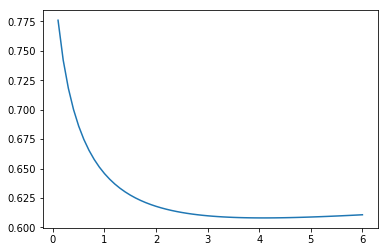

In [141]:
alpha = 0
betaU = defaultdict(int)
betaI = defaultdict(int)
plotLambda = []
plotMSE = []
p = 0
for i in range(0, 60):
    p += 0.1
    plotLambda.append(p)
    while(True):
        oldAlpha = alpha
        alphaUpdate()
        betaUUpdate(p)
        betaIUpdate(p)
        if(abs(oldAlpha - alpha) <= 0.000001):
            break
    plotMSE.append(predictRating())
    alpha = 0
    betaU = defaultdict(int)
    betaI = defaultdict(int)

print("done")

import matplotlib.pyplot as plt
plt.plot(plotLambda, plotMSE)
plt.show()

In [143]:
print(plotLambda[np.argmin(plotMSE)])
print(plotMSE[np.argmin(plotMSE)])

4.100000000000001
0.607994393749


In [144]:
alpha = 0
betaU = defaultdict(int)
betaI = defaultdict(int)
while(True):
    oldAlpha = alpha
    alphaUpdate()
    betaUUpdate(4.1)
    betaIUpdate(4.1)
    if(abs(oldAlpha - alpha) <= 0.000001):
        break
print(predictRating())

0.607994393749


In [147]:
def ratingPredFile(inputFile, outputFile):
    global alpha
    global betaU
    global betaI
    predictions = open(outputFile, 'w')
    for l in open(inputFile):
        if l.startswith("userID"):
            predictions.write(l)
            continue
        user,business = l.strip().split('-')
        prediction = alpha
        if user in betaU:
            prediction += betaU[user]
        if business in betaI:
            prediction += betaI[business]
        predictions.write(user + '-' + business + "," + str(prediction)+"\n")

ratingPredFile("pairs_Rating.txt","predictions_Rating.txt")